## Random Forest - __версия 4__

Disclaimer:

В предыдущей версии использовался TF-IDF для текстовых признаков `rfq_text` и `supplier_text`, а multilingual embeddings — только для полей `products`, `product_categories`, `keywords`. Логистическая регрессия показала accuracy 57.4%.

В данной версии:
- **Полный отказ от TF-IDF** — текстовые поля кодируются через SentenceTransformer:
  - `rfq_text` и `supplier_text` → **all-MiniLM-L6-v2** (384 dim) — компактная английская модель для семантического сходства запроса и поставщика.
  - `multilingual_text` (products, categories, keywords) → **paraphrase-multilingual-MiniLM-L12-v2** (384 dim) — multilingual модель для текстов на разных языках (DE, EN и др.).
- **Cosine similarity** между эмбеддингами `rfq_text` и `supplier_text` / `multilingual_text` как дополнительные признаки — модель напрямую видит степень семантического сходства.
- **RandomForestClassifier** вместо LogisticRegression — нелинейная модель, лучше работает с высокоразмерными эмбеддингами и может находить сложные паттерны.

Классификация: тип совпадения RFQ–Supplier (match, weak_match, related, no_match).

---
## 1. Импорты и настройки


In [12]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer

---
## 2. Загрузка данных

In [13]:
data_path = Path("dataset/dataset_10k.csv")
df = pd.read_csv(data_path)

print("Форма датасета:", df.shape)
print("Колонки:", df.columns)

Форма датасета: (10000, 15)
Колонки: Index(['rfq_id', 'rfq_title', 'rfq_description', 'quantity',
       'delivery_location', 'rfq_supplier_types', 'supplier_name',
       'supplier_country', 'distribution_area', 'supplier_description',
       'supplier_types', 'products', 'product_categories', 'keywords',
       'match_type'],
      dtype='object')


---
## 3. Предобработка

Очистка полей в формате PostgreSQL-массивов (фигурные скобки), подсчёт пропусков, заполнение пропусков в текстовых полях, формирование признаков `rfq_text` и `supplier_text`.

In [14]:
def clean_array_field(s: str) -> str:
    if pd.isna(s):
        return ""
   
    s = str(s).strip()
    if s.startswith("{") and s.endswith("}"):
        s = s[1:-1]

    return s.replace(",", ", ")

# Колонки в формате массива
array_columns = [
    "rfq_supplier_types", "supplier_types", "products", "product_categories", "keywords"
]
for col in array_columns:
    if col in df.columns:
        df[col] = df[col].apply(clean_array_field)


df.head()

,rfq_id,rfq_title,rfq_description,quantity,delivery_location,rfq_supplier_types,supplier_name,supplier_country,distribution_area,supplier_description,supplier_types,products,product_categories,keywords,match_type
0,93c75bb7-1545-4279-aada-6d66b9c9e62e,electric kick scooters e-scooters,New family startup; looking for: e-scooter for...,10,"Heilbronn, Deutschland","PRODUCTION, WHOLESALER, DISTRIBUTION",Yatdim GmbH,DE,international,Yatdim GmbH – Your Partner for E-Mobility Whol...,"Distribution, Production, Wholesaler",E-Bike BURCHDA RX80 fully suspended mountain b...,Vehicles,"Burchda RX80 Elektrofahrrad, E Mountainbike 26...",weak_match
1,93c75bb7-1545-4279-aada-6d66b9c9e62e,electric kick scooters e-scooters,New family startup; looking for: e-scooter for...,10,"Heilbronn, Deutschland","PRODUCTION, WHOLESALER, DISTRIBUTION",Erler Mobile GmbH,DE,europe,Erler Mobile produces electric scooters and el...,"Production, Distribution, Wholesaler","Industrieroller COLLY 1, Industrieroller COLLY...",Fahrzeuge,"Industrieroller, Transportroller für Personen,...",related
2,93c75bb7-1545-4279-aada-6d66b9c9e62e,electric kick scooters e-scooters,New family startup; looking for: e-scooter for...,10,"Heilbronn, Deutschland","PRODUCTION, WHOLESALER, DISTRIBUTION",Yatdim GmbH,DE,international,Yatdim GmbH – Your Partner for E-Mobility Whol...,"Wholesaler, Production, Distribution","""E-Bike Onesport OT16 Klappbares Elektrofahrra...",Fahrzeuge,"OneSport OT16 Elektrofahrrad, E Bike klappbar ...",related
3,93c75bb7-1545-4279-aada-6d66b9c9e62e,electric kick scooters e-scooters,New family startup; looking for: e-scooter for...,10,"Heilbronn, Deutschland","PRODUCTION, WHOLESALER, DISTRIBUTION",Sauter Engineering + Design GmbH,DE,international,Sauter Engineering + Design GmbH stands for ta...,Service,"Product Development - Design, Product Developm...","""Planning, engineering and development""","""Product Development "", Produktentwicklung, De...",no_match
4,93c75bb7-1545-4279-aada-6d66b9c9e62e,electric kick scooters e-scooters,New family startup; looking for: e-scooter for...,10,"Heilbronn, Deutschland","PRODUCTION, WHOLESALER, DISTRIBUTION",EVENTTRUCK MASTERS,BE,europe,Event Truck Masters is a company specializing ...,"Wholesaler, Distribution","""FOODTRUCKS for sale and rent, suitable for a...",Vehicles,"Foordtrucks, Food trucks, Location de food tru...",no_match


In [15]:
# Количество пропусков по колонкам до заполнения
nan_counts = df.isna().sum()
print("Пропуски по колонкам (до заполнения):")
for col in df.columns:
    if nan_counts[col] > 0:
        print(f"  {col}: {nan_counts[col]}")

Пропуски по колонкам (до заполнения):
  distribution_area: 1788
  supplier_description: 471


In [16]:
# Заполняем пропуски в текстовых полях пустой строкой
text_columns = [
    "rfq_title", "rfq_description", "delivery_location", "quantity",
    "rfq_supplier_types", "supplier_name", "supplier_country", "distribution_area",
    "supplier_description", "supplier_types", "products", "product_categories", "keywords"
]
for col in text_columns:
    if col in df.columns:
        df[col] = df[col].fillna("").astype(str)

In [17]:
# Текстовые признаки: rfq_text (RFQ), supplier_text (поставщик)
df["rfq_text"] = (
    df["rfq_title"].astype(str) + " "
    + df["rfq_description"].astype(str) + " "
    + df["delivery_location"].astype(str) + " "
    + df["quantity"].astype(str) + " "
    + df["rfq_supplier_types"].astype(str)
)

# supplier_text без multilingual полей (products, product_categories, keywords)
# — они будут обработаны отдельно через multilingual sentence embeddings
df["supplier_text"] = (
    df["supplier_name"].astype(str) + " "
    + df["supplier_description"].astype(str) + " "
    + df["distribution_area"].astype(str) + " "
    + df["supplier_country"].astype(str) + " "
    + df["supplier_types"].astype(str)
)

# Объединяем multilingual поля для получения эмбеддингов
df["multilingual_text"] = (
    df["products"].astype(str) + " "
    + df["product_categories"].astype(str) + " "
    + df["keywords"].astype(str)
)

---
## 3.1. Sentence Embeddings и косинусное сходство

Вместо TF-IDF используем две SentenceTransformer модели:

- **all-MiniLM-L6-v2** (384 dim) — для `rfq_text` и `supplier_text`. Компактная английская модель, хорошо подходит для семантического сравнения запроса и описания поставщика.
- **paraphrase-multilingual-MiniLM-L12-v2** (384 dim) — для `multilingual_text` (products, product_categories, keywords). Multilingual модель, отображает тексты на 50+ языках (DE, EN и др.) в единое пространство эмбеддингов.

Дополнительно вычисляем **cosine similarity** между:
- `rfq_text` ↔ `supplier_text` — насколько запрос семантически близок к описанию поставщика
- `rfq_text` ↔ `multilingual_text` — насколько запрос соответствует товарам/категориям поставщика

Итоговые признаки: эмбеддинги (384 × 3 = 1152 dim) + 2 косинусных сходства = **1154 признака**.

In [ ]:
st_model = SentenceTransformer("all-MiniLM-L6-v2")
ml_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

print("Encoding rfq_text (all-MiniLM-L6-v2)...")
rfq_embeddings = st_model.encode(
    df["rfq_text"].tolist(), show_progress_bar=True, batch_size=64
)

print("Encoding supplier_text (all-MiniLM-L6-v2)...")
supplier_embeddings = st_model.encode(
    df["supplier_text"].tolist(), show_progress_bar=True, batch_size=64
)

print("Encoding multilingual_text (paraphrase-multilingual-MiniLM-L12-v2)...")
multilingual_embeddings = ml_model.encode(
    df["multilingual_text"].tolist(), show_progress_bar=True, batch_size=64
)

# Косинусное сходство (поэлементно, каждая строка — пара rfq ↔ supplier)
cos_rfq_supplier = np.array([
    cosine_similarity(r.reshape(1, -1), s.reshape(1, -1))[0, 0]
    for r, s in zip(rfq_embeddings, supplier_embeddings)
])
cos_rfq_multilingual = np.array([
    cosine_similarity(r.reshape(1, -1), m.reshape(1, -1))[0, 0]
    for r, m in zip(rfq_embeddings, multilingual_embeddings)
])

# Добавляем эмбеддинги как колонки
rfq_emb_cols = [f"rfq_emb_{i}" for i in range(rfq_embeddings.shape[1])]
sup_emb_cols = [f"sup_emb_{i}" for i in range(supplier_embeddings.shape[1])]
ml_emb_cols = [f"ml_emb_{i}" for i in range(multilingual_embeddings.shape[1])]

df[rfq_emb_cols] = pd.DataFrame(rfq_embeddings, index=df.index)
df[sup_emb_cols] = pd.DataFrame(supplier_embeddings, index=df.index)
df[ml_emb_cols] = pd.DataFrame(multilingual_embeddings, index=df.index)

# Добавляем cosine similarity
df["cos_rfq_supplier"] = cos_rfq_supplier
df["cos_rfq_multilingual"] = cos_rfq_multilingual

emb_cols = rfq_emb_cols + sup_emb_cols + ml_emb_cols
sim_cols = ["cos_rfq_supplier", "cos_rfq_multilingual"]
feature_cols = emb_cols + sim_cols

print(f"\nМодели:")
print(f"  rfq_text, supplier_text → all-MiniLM-L6-v2 ({rfq_embeddings.shape[1]} dim)")
print(f"  multilingual_text → paraphrase-multilingual-MiniLM-L12-v2 ({multilingual_embeddings.shape[1]} dim)")
print(f"Эмбеддинги: {len(emb_cols)} колонок (3 × 384)")
print(f"Cosine similarity: {len(sim_cols)} колонок")
print(f"Всего признаков: {len(feature_cols)}")
print(f"\nCosine similarity stats (rfq ↔ supplier): mean={cos_rfq_supplier.mean():.3f}, std={cos_rfq_supplier.std():.3f}")
print(f"Cosine similarity stats (rfq ↔ multilingual): mean={cos_rfq_multilingual.mean():.3f}, std={cos_rfq_multilingual.std():.3f}")

---
## 4. Разбиение на обучающую, валидационную и тестовую выборки (60 / 20 / 20)

Используется **GroupShuffleSplit** по ключу `rfq_id`: все строки одного RFQ попадают в одну выборку. Сначала отделяем 60% групп в train и 40% во временную выборку; затем делим временную пополам — 20% validation, 20% test.

In [19]:
y = df["match_type"]
groups = df["rfq_id"]

# 60% train, 40% временная выборка (будущие val + test)
gss1 = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=42)
train_idx, temp_idx = next(gss1.split(df, y, groups))

# Из 40% временной: половина validation, половина test (20% и 20% от всего)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=43)
val_idx, test_idx = next(gss2.split(df.iloc[temp_idx], y.iloc[temp_idx], groups.iloc[temp_idx]))
val_idx = np.array(temp_idx)[val_idx]
test_idx = np.array(temp_idx)[test_idx]

X_train = df.loc[train_idx, feature_cols]
y_train = y.iloc[train_idx]
X_val = df.loc[val_idx, feature_cols]
y_val = y.iloc[val_idx]
X_test = df.loc[test_idx, feature_cols]
y_test = y.iloc[test_idx]

print("Размер обучающей выборки (train):", len(X_train))
print("Размер валидационной выборки (validation):", len(X_val))
print("Размер тестовой выборки (test):", len(X_test))
print(f"Количество признаков: {X_train.shape[1]}")

Размер обучающей выборки (train): 5878
Размер валидационной выборки (validation): 2148
Размер тестовой выборки (test): 1974
Количество признаков: 1154


---
## 5. Модель и обучение

Признаки (все числовые, pipeline не нужен):
1. **Эмбеддинги rfq_text** (384 dim, all-MiniLM-L6-v2) — семантическое представление запроса
2. **Эмбеддинги supplier_text** (384 dim, all-MiniLM-L6-v2) — семантическое представление поставщика
3. **Эмбеддинги multilingual_text** (384 dim, paraphrase-multilingual-MiniLM-L12-v2) — товары, категории, ключевые слова на разных языках
4. **Cosine similarity rfq ↔ supplier** — мера семантического сходства запроса и поставщика
5. **Cosine similarity rfq ↔ multilingual** — мера соответствия запроса товарам поставщика

Классификатор: **LogisticRegression** с `class_weight='balanced'` для учёта дисбаланса классов. В отличие от RandomForest, линейная модель лучше использует структуру эмбеддингового пространства.

In [20]:
clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42,
)

clf.fit(X_train, y_train)

# Предсказания: на validation (для подбора гиперпараметров) и на test (финальная оценка)
y_pred_val = clf.predict(X_val)
y_pred = clf.predict(X_test)

---
## 6. Оценка качества и визуализация

In [21]:
print("Validation (accuracy):", round(accuracy_score(y_val, y_pred_val), 4))
print()
print("Test — classification report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Test — accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nConfusion matrix (test):")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Validation (accuracy): 0.5098

Test — classification report:
              precision    recall  f1-score   support

       match       0.56      0.45      0.50       609
    no_match       0.78      0.68      0.73      1173
     related       0.10      0.28      0.14        81
  weak_match       0.10      0.21      0.14       111

    accuracy                           0.57      1974
   macro avg       0.39      0.41      0.38      1974
weighted avg       0.65      0.57      0.60      1974

Test — accuracy: 0.5669

Confusion matrix (test):
[[273 155  83  98]
 [167 800 114  92]
 [ 22  27  23   9]
 [ 25  41  22  23]]


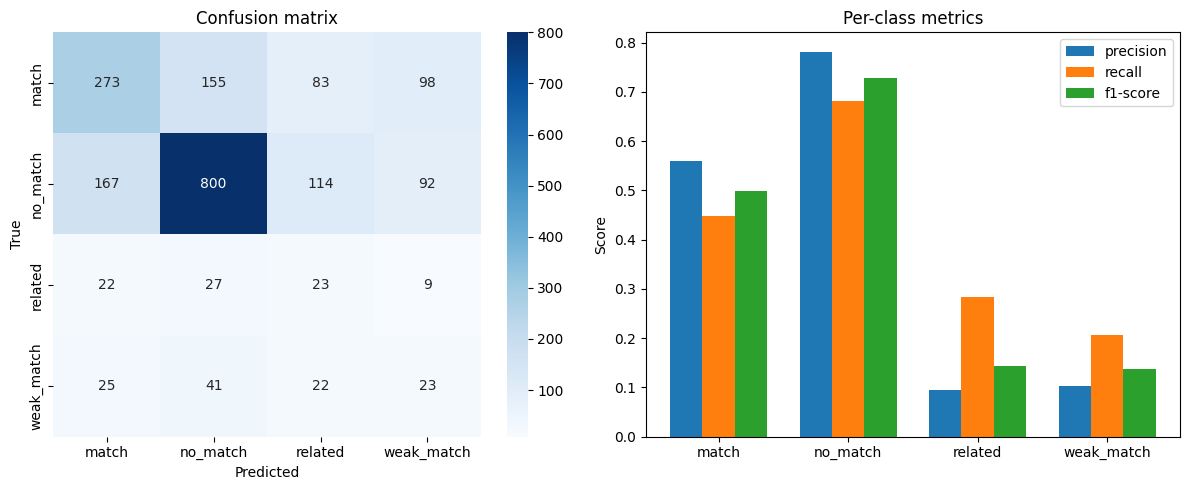

In [22]:
labels = sorted(y.unique())
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Матрица ошибок
sns.heatmap(
    cm, xticklabels=labels, yticklabels=labels, annot=True, fmt="d",
    cmap="Blues", ax=axes[0]
)
axes[0].set_title("Confusion matrix")
axes[0].set_ylabel("True")
axes[0].set_xlabel("Predicted")

# Метрики по классам
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
metrics = ["precision", "recall", "f1-score"]
x = np.arange(len(labels))
width = 0.25
for i, m in enumerate(metrics):
    vals = [report[l].get(m, 0) for l in labels]
    axes[1].bar(x + i * width, vals, width, label=m)
    
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(labels)
axes[1].set_ylabel("Score")
axes[1].set_title("Per-class metrics")
axes[1].legend()

plt.tight_layout()
plt.show()

## Выводы

### Что изменилось в версии 4

В данной версии:
- **Полный отказ от TF-IDF** — текстовые поля кодируются через SentenceTransformer:
  - `rfq_text`, `supplier_text` → **all-MiniLM-L6-v2** (384 dim) — компактная английская модель для семантического сравнения запроса и поставщика.
  - `multilingual_text` → **paraphrase-multilingual-MiniLM-L12-v2** (384 dim) — multilingual модель для текстов на разных языках (DE, EN и др.).
- **Cosine similarity как признаки**: вычислены попарные косинусные сходства `rfq_text ↔ supplier_text` и `rfq_text ↔ multilingual_text` — модель напрямую видит степень семантической близости.
- **LogisticRegression** с `class_weight='balanced'` — линейная модель, хорошо работающая со структурой эмбеддингового пространства.
- Итого 1154 признака: 3 × 384 эмбеддинга + 2 cosine similarity.

**Примечание**: первоначально в данной версии был использован **RandomForestClassifier**, однако он показал крайне плохие результаты (accuracy 60.1%, но предсказывал почти всё как `no_match` — recall для match=2%, related=0%, weak_match=0%). RandomForest плохо работает с высокоразмерными эмбеддингами, так как деревья решений разбивают пространство по отдельным признакам, а семантическая информация в эмбеддингах распределена по всем 384 измерениям одновременно. Поэтому модель была заменена обратно на LogisticRegression.

### Сравнение с версией 3

| Метрика | v3 (TF-IDF + multilingual emb) | v4 (Embeddings + cosine sim) | Изменение |
|---------|-------------------------------|------------------------------|-----------|
| **Test accuracy** | 57.4% | **56.7%** | −0.7% |
| **Macro avg f1** | 0.35 | **0.38** | **+0.03** |
| **Weighted avg f1** | 0.58 | **0.60** | **+0.02** |
| match f1 | 0.43 | **0.50** | **+0.07** |
| no_match f1 | 0.73 | 0.73 | 0 |
| related f1 | 0.12 | **0.14** | **+0.02** |
| weak_match f1 | 0.13 | **0.14** | **+0.01** |

### Анализ результатов

**Test accuracy: 56.7%** — формально чуть ниже, чем в v3 (57.4%), однако по более важным метрикам модель стала лучше.

**Главное улучшение — распознавание match:**
- **match recall: 45% vs 35%** (v3) — модель стала значительно лучше находить реальные совпадения. Из 609 match верно предсказаны 273 (было 213).
- **match f1: 0.50 vs 0.43** — наиболее значительный рост среди всех классов.

**Миноритарные классы (related, weak_match) тоже улучшились:**
- **related recall: 28% vs 19%** — рост почти в 1.5 раза. Из 81 related верно определены 23 (было 15).
- **weak_match recall: 21% vs 17%** — из 111 weak_match верно предсказаны 23 (было 19).
- Precision для обоих классов остаётся низкой (~10%), но модель стала чаще «рисковать» предсказаниями этих классов, что повышает recall.

**no_match — перераспределение ошибок:**
- **Precision выросла: 78% vs 71%** — когда модель предсказывает no_match, она чаще права.
- **Recall снизился: 68% vs 75%** — модель стала реже «прятаться» за no_match, перераспределяя предсказания в пользу остальных классов.
- **f1 остался на том же уровне: 0.73**.

**Снижение accuracy объясняется перераспределением предсказаний**: модель стала чаще предсказывать миноритарные классы (related, weak_match), что неизбежно ведёт к дополнительным ошибкам из-за их малого размера, но при этом увеличивает recall для всех классов.

### Ключевые наблюдения

1. **Эмбеддинги лучше TF-IDF для семантического сопоставления**: замена TF-IDF на sentence embeddings позволила модели лучше различать match и no_match, а также частично распознавать related и weak_match. Это подтверждает, что семантические эмбеддинги захватывают смысловое сходство, недоступное для bag-of-words подхода.

2. **Cosine similarity — полезный признак**: два дополнительных признака (cosine similarity rfq ↔ supplier, rfq ↔ multilingual) дают модели прямой сигнал о степени сходства, что особенно важно для разделения match/no_match.

3. **LogisticRegression лучше RandomForest для эмбеддингов**: линейная модель естественно работает с геометрической структурой эмбеддингового пространства (направления и расстояния), тогда как RandomForest разбивает пространство по отдельным координатам, теряя семантический смысл.

4. **Macro avg f1 вырос (0.38 vs 0.35)** — это наиболее объективная метрика для несбалансированных данных, и её рост говорит о реальном улучшении качества модели.